# 设置随机种子

In [ ]:
"""fix the random seed"""

seed = 2020

# 设置随机种子确保每次随机的结果相同
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

* torch.backends.cudnn.deterministic = True 的作用是让CuDNN在卷积操作中使用确定性算法，以保证每次运行卷积操作时得到的结果都是相同的。这种设置会影响到卷积操作的性能，因为CuDNN的自动优化机制会被禁用
* torch.backends.cudnn.benchmark = False 的作用是让CuDNN在卷积操作中使用固定算法，以保证每次运行卷积操作时得到的结果都是相同的

# 读取参数

In [ ]:
"""read args"""
global args, device
args = parse_args()
device = torch.device("cuda:" + str(args.gpu_id)) if args.cuda else torch.device("cpu")

In [ ]:
import argparse


def parse_args():
    parser = argparse.ArgumentParser(description="VRKG")

    # ===== dataset ===== #
    parser.add_argument("--dataset", nargs="?", default="movie-MKR", help="Choose a dataset:[last-fm, movie]")
    parser.add_argument(
        "--data_path", nargs="?", default="data/", help="Input data path."
    )

    # ===== train ===== #
    parser.add_argument('--epoch', type=int, default=1000, help='number of epochs')
    parser.add_argument('--batch_size', type=int, default=1024, help='batch size')
    parser.add_argument('--test_batch_size', type=int, default=128, help='batch size')
    parser.add_argument('--dim', type=int, default=64, help='embedding size')
    parser.add_argument('--l2', type=float, default=1e-5, help='l2 regularization weight')
    parser.add_argument('--kg_l2loss_lambda', type=float, default=1e-5,
                        help='Lambda when calculating KG l2 loss.')
    parser.add_argument('--lr', type=float, default=1e-4, help='learning rate')
    parser.add_argument("--inverse_r", type=bool, default=True, help="consider inverse relation or not")
    parser.add_argument("--node_dropout", type=bool, default=True, help="consider node dropout or not")
    parser.add_argument("--node_dropout_rate", type=float, default=0.5, help="ratio of node dropout")
    parser.add_argument("--mess_dropout", type=bool, default=True, help="consider message dropout or not")
    parser.add_argument("--mess_dropout_rate", type=float, default=0.1, help="ratio of node dropout")
    parser.add_argument("--batch_test_flag", type=bool, default=True, help="use gpu or not")
    parser.add_argument("--channel", type=int, default=64, help="hidden channels for model")
    parser.add_argument("--cuda", type=bool, default=True, help="use gpu or not")
    parser.add_argument("--gpu_id", type=int, default=0, help="gpu id")
    parser.add_argument('--Ks', nargs='?', default='[1, 5, 10, 20]', help='Output sizes of every layer')

    parser.add_argument('--test_flag', nargs='?', default='part',
                        help='Specify the test type from {part, full}, indicating whether the reference is done in mini-batch')
    parser.add_argument("--n_virtual", type=int, default=3, help="number of latent factor for user favour")
    parser.add_argument("--ind", type=str, default='distance', help="Independence modeling: mi, distance, cosine")

    # ===== relation context ===== #
    parser.add_argument('--context_hops', type=int, default=2, help='number of context hops')
    parser.add_argument('--n_iter', type=int, default=3, help='number of n_iter')

    # ===== save model ===== #
    parser.add_argument("--save", type=bool, default=False, help="save model or not")
    parser.add_argument("--out_dir", type=str, default="./weights/", help="output directory for model")

    return parser.parse_args()

读取预设的参数，并指定训练是使用gpu还是cpu

# 建立数据集

In [ ]:
"""build dataset"""

train_cf, test_cf, user_dict, n_params, graph, triplets, relation_dict, mat_list = load_data(args)

adj_mat_list, norm_mat_list, mean_mat_list = mat_list

n_users = n_params['n_users']
n_items = n_params['n_items']
n_entities = n_params['n_entities']
n_relations = n_params['n_relations']
n_nodes = n_params['n_nodes']

In [ ]:
"""train_cf, test_cf, user_dict, n_params, graph, triplets, relation_dict, mat_list = load_data(args)"""

def load_data(model_args):
    
    global args
    
    # 把args传给args
    args = model_args
    
    # dataset路径
    directory = args.data_path + args.dataset + '/'

    print('reading train and test user-item set ...')
    n_user, n_item, train_data, test_data = load_rating(args)
    # n_entity, n_relation, adj_entity, adj_relation = load_kg(args)
    
    # 获取train和test集的协同过滤数据
    train_cf = read_cf(train_data)
    test_cf = read_cf(test_data)
    remap_item(train_cf, test_cf)

    print('combinating train_cf and kg data ...')
    triplets = read_triplets(directory + 'kg_final.txt')

    print('building the graph ...')
    graph, relation_dict = build_graph(train_cf, triplets)

    print('building the adj mat ...')
    adj_mat_list, norm_mat_list, mean_mat_list = build_sparse_relational_graph(relation_dict)

    n_params = {
        'n_users': int(n_users),
        'n_items': int(n_items),
        'n_entities': int(n_entities),
        'n_nodes': int(n_nodes),
        'n_relations': int(n_relations)
    }
    user_dict = {
        'train_user_set': train_user_set,
        'test_user_set': test_user_set
    }

    return train_cf, test_cf, user_dict, n_params, graph, triplets, relation_dict,\
           [adj_mat_list, norm_mat_list, mean_mat_list]


In [ ]:
"""n_user, n_item, train_data, test_data = load_rating(args)"""

def load_rating(args):
    
    print('reading training file and testing file ...')
    directory = 'data/' + args.dataset
    
    # rating_np = np.loadtxt(rating_file + '.txt', dtype=np.int64)
    with open(directory + "/train_data.pkl", 'rb') as fo:
        train_data = pickle.load(fo, encoding='bytes')
    with open(directory + "/test_data.pkl", 'rb') as fi:
        test_data = pickle.load(fi, encoding='bytes')
    rating_np = np.concatenate((train_data, test_data), axis=0)

    # 因为数据索引从0开始，所以在计数时需要+1
    n_user = max(set(rating_np[:, 0])) + 1  # the result = max(rating_np[:, 0]
    n_item = max(set(rating_np[:, 1])) + 1  # the result = max(rating_np[:, 1]

    return n_user, n_item, train_data, test_data


train_data(user-item): <br/> idx_0: user_id <br/> idx_1: item_id <br/> idx_2: flag <br/> 返回用户个数，项目个数，训练集，测试集

In [ ]:
def read_cf(data_name):
    
    inter_mat = data_name[:, :2]
    return np.array(inter_mat)

这个函数的作用是读取data_name前两列数据，也就是user和item的交互数据，即协同过滤(Collaborative Filtering)模型的输入数据

In [ ]:
train_user_set = defaultdict(list)
test_user_set = defaultdict(list)

def remap_item(train_data, test_data):
    
    global n_users, n_items
    
    # 从训练集和测试集中找到user的最大id
    n_users = max(max(train_data[:, 0]), max(test_data[:, 0])) + 1
    # 从训练集和测试集中找到item的最大id
    n_items = max(max(train_data[:, 1]), max(test_data[:, 1])) + 1

    for u_id, i_id in train_data:
        train_user_set[int(u_id)].append(int(i_id))
    for u_id, i_id in test_data:
        test_user_set[int(u_id)].append(int(i_id))

从两个集合中构造一个字典，即每个user交互的item的字典，如下图所示
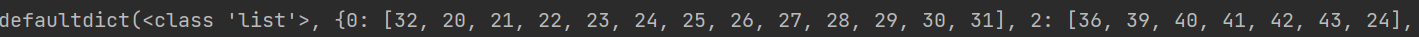

In [ ]:
"""triplets = read_triplets(directory + 'kg_final.txt')"""

def read_triplets(file_name):
    
    # 实体、关系、节点
    global n_entities, n_relations, n_nodes
    
    # 对于读取txt文件
    can_triplets_np = np.loadtxt(file_name, dtype=np.int32)
    
    # axis=0 表示对三元组中的每一列进行去重，即在所有行中去除重复的三元组，确保每个三元组只出现一次
    can_triplets_np = np.unique(can_triplets_np, axis=0)

    
    # 同时考虑关系的主被动形式
    if args.inverse_r:
        
        # get triplets with inverse direction like <entity, is-aspect-of, item>
        inv_triplets_np = can_triplets_np.copy()
        inv_triplets_np[:, 0] = can_triplets_np[:, 2]
        inv_triplets_np[:, 2] = can_triplets_np[:, 0]
        inv_triplets_np[:, 1] = can_triplets_np[:, 1] + max(can_triplets_np[:, 1]) + 1
        
        # consider two additional relations --- 'interact' and 'be interacted'
        # 给每个关系值+1 去除0？
        can_triplets_np[:, 1] = can_triplets_np[:, 1] + 1
        inv_triplets_np[:, 1] = inv_triplets_np[:, 1] + 1
        
        # get full version of knowledge graph
        # 将两个triplets合并组成完整的triplets
        triplets = np.concatenate((can_triplets_np, inv_triplets_np), axis=0)
    else:
        # consider two additional relations --- 'interact'.
        can_triplets_np[:, 1] = can_triplets_np[:, 1] + 1
        triplets = can_triplets_np.copy()

    n_entities = max(max(triplets[:, 0]), max(triplets[:, 2])) + 1  # including items + users
    n_nodes = n_entities + n_users
    n_relations = max(triplets[:, 1]) + 1

    return triplets

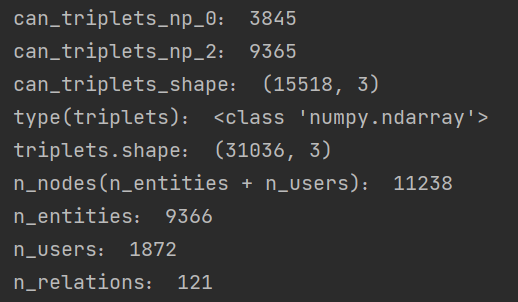
* n_entities：实体个数
* n_nodes：节点个数（entities + user）
* n_relations：关系个数（主被动）
* triplets：三元组（双向关系三元组）

In [ ]:
"""graph, relation_dict = build_graph(train_cf, triplets)"""

def build_graph(train_data, triplets):
    
    #  MultiDiGraph() 方法可以创建一个可以存储重复边和自环的有向图
    ckg_graph = nx.MultiDiGraph()
    
    # 创建一个空字典
    rd = defaultdict(list)

    print("Begin to load interaction triples ...")
    for u_id, i_id in tqdm(train_data, ascii=True):
        
        # 将所有u_id和i_id对存入rd中k=0的key中
        rd[0].append([u_id, i_id])

    print("\nBegin to load knowledge graph triples ...")
    for h_id, r_id, t_id in tqdm(triplets, ascii=True):
        
        # 把头、尾实体和关系加入ckg_graph
        ckg_graph.add_edge(h_id, t_id, key=r_id)
        
        # 在字典中添加以r_id为ket的头尾实体组，r_id以1开始
        rd[r_id].append([h_id, t_id])

    return ckg_graph, rd

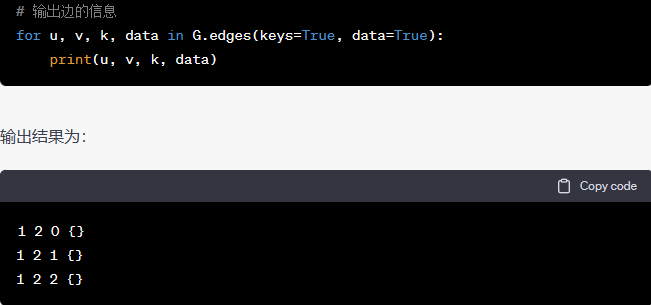
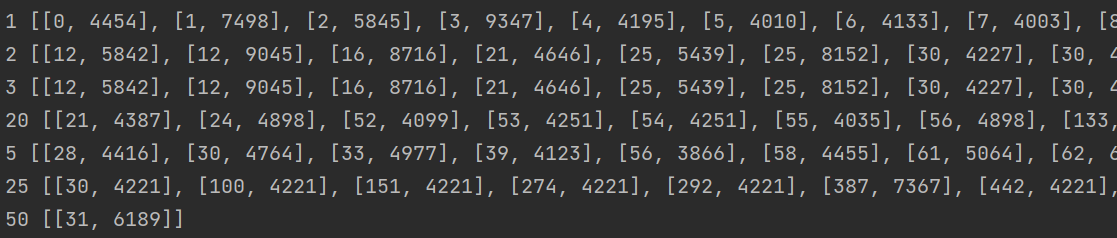

In [ ]:
"""adj_mat_list, norm_mat_list, mean_mat_list = build_sparse_relational_graph(relation_dict)"""

def build_sparse_relational_graph(relation_dict):
    
    def _bi_norm_lap(adj):
        # D^{-1/2}AD^{-1/2}
        rowsum = np.array(adj.sum(1))

        d_inv_sqrt = np.power(rowsum, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt)

        # bi_lap = adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt)
        bi_lap = d_mat_inv_sqrt.dot(adj).dot(d_mat_inv_sqrt)
        return bi_lap.tocoo()

    def _si_norm_lap(adj):
        # D^{-1}A
        rowsum = np.array(adj.sum(1))

        d_inv = np.power(rowsum, -1).flatten()
        d_inv[np.isinf(d_inv)] = 0.
        d_mat_inv = sp.diags(d_inv)

        norm_adj = d_mat_inv.dot(adj)
        return norm_adj.tocoo()

    # 邻接矩阵列表
    adj_mat_list = []
    
    print("Begin to build sparse relation matrix ...")
    
    # 遍历relation_dict的key，也就是关系id
    for r_id in tqdm(relation_dict.keys()):
        # 取出当前关系下的元素值
        np_mat = np.array(relation_dict[r_id])
        # rd[0]存储的是train_data中所有u_id，i_id对
        if r_id == 0:
            # cf新开辟空间复制np_mat
            cf = np_mat.copy()
            # 提取出每行第2列加上user数目1872？
            cf[:, 1] = cf[:, 1] + n_users  # [0, n_items) -> [n_users, n_users+n_items)
            # 创建一个len(cf)长的一维数组
            vals = [1.] * len(cf)
            # 在(cf[:, 0], cf[:, 1])的位置上插入元素1，且adj_matrix大小为n_nodes x n_nodes
            # 问题是cf中只有user和item的交互，为什么要包含所有entity呢？
            adj = sp.coo_matrix((vals, (cf[:, 0], cf[:, 1])), shape=(n_nodes, n_nodes))
        else:
            # 当前关系下存在的
            vals = [1.] * len(np_mat)
            # 给每一个关系都建立一个稀疏矩阵
            adj = sp.coo_matrix((vals, (np_mat[:, 0], np_mat[:, 1])), shape=(n_nodes, n_nodes))
            
        # 所有的稀疏矩阵存储    
        adj_mat_list.append(adj)
    
    # 双侧标准化拉普拉斯矩阵
    norm_mat_list = [_bi_norm_lap(mat) for mat in adj_mat_list]
    # 单侧标准化拉普拉斯矩阵
    mean_mat_list = [_si_norm_lap(mat) for mat in adj_mat_list]
    
    # interaction: user->item, [n_users, n_entities]
    # 截取右上角1872x1872大小的矩阵
    norm_mat_list[0] = norm_mat_list[0].tocsr()[:n_users, n_users:].tocoo()
    mean_mat_list[0] = mean_mat_list[0].tocsr()[:n_users, n_users:].tocoo()

    return adj_mat_list, norm_mat_list, mean_mat_list

# 整理数据

In [ ]:
    """cf data"""
    train_cf_pairs = torch.LongTensor(np.array([[cf[0], cf[1]] for cf in train_cf], np.int32))
    test_cf_pairs = torch.LongTensor(np.array([[cf[0], cf[1]] for cf in test_cf], np.int32))

    """kg data"""
    train_kg_pairs = torch.LongTensor(np.array([[kg[0], kg[1], kg[2]] for kg in triplets], np.int32))

将np.array数据转化为tensor数据类型

# 定义模型

In [ ]:
    """define model"""
    model = Recommender(n_params, args, graph, mean_mat_list[0]).to(device)

# 定义优化器

In [ ]:
    """define optimizer"""
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

    cur_best_pre_0 = 0
    stopping_step = 0
    best_epoch = 0
    should_stop = False

# 训练流程

In [ ]:
 print("start training ...")
    for epoch in range(args.epoch):
        
        """training CF"""
        
        # shuffle training data
        # 打乱训练数据
        index = np.arange(len(train_cf))
        np.random.shuffle(index)
        train_cf_pairs = train_cf_pairs[index]

        """ training """
        """ train cf """
        # s = start
        mf_loss_total, s = 0, 0
        train_cf_s = time()
        model.train()
        flag = 'cf'
        
        # 当 s 和 args.batch_size 小于 len(train_cf)
        while s + args.batch_size <= len(train_cf):
            cf_batch = get_feed_dict(train_cf_pairs,
                                     s, s + args.batch_size,
                                     user_dict['train_user_set'])
            
            batch_loss, mf_loss, _ = model(cf_batch)

            optimizer.zero_grad()
            mf_loss.backward()
            optimizer.step()

            mf_loss_total += mf_loss.item()
            s += args.batch_size

        train_cf_e = time()

        if epoch % 10 == 9 or epoch == 1:
            """testing"""
            test_s_t = time()
            model.eval()
            ret = test(model, user_dict, n_params)
            test_e_t = time()

            train_res = PrettyTable()
            train_res.field_names = ["Epoch", "training time", "testing time", "recall", "ndcg", "precision",
                                     "hit_ratio", "auc", "f1"]
            train_res.add_row(
                [epoch, train_cf_e - train_cf_s, test_e_t - test_s_t, ret['recall'], ret['ndcg'], ret['precision'],
                 ret['hit_ratio'], ret['auc'], ret['f1']]
            )
            print(train_res)

            # *********************************************************
            # early stopping when cur_best_pre_0 is decreasing for 10 successive steps.
            cur_best_pre_0, stopping_step, should_stop, best_epoch = early_stopping(ret['recall'][0], cur_best_pre_0,
                                                                                    stopping_step, best_epoch, epoch,
                                                                                    expected_order='acc',
                                                                                    flag_step=10)
            if should_stop:
                break

            """save weight"""
            if ret['recall'][0] == cur_best_pre_0 and args.save:
                torch.save(model.state_dict(), args.out_dir + 'model_' + args.dataset + '.ckpt')

        else:
            print('using time %.4f, training loss at epoch %d: %.4f' % (train_cf_e - train_cf_s, epoch, mf_loss_total))

    print('stopping at %d, recall@20:%.4f' % (epoch, ret['recall'][0]))
    print('the best epoch is at %d, recall@20:%.4f' % (best_epoch, cur_best_pre_0))

# #1 get_feed_dict()

In [ ]:
"""cf_batch = get_feed_dict(train_cf_pairs, s, s + args.batch_size, user_dict['train_user_set'])"""

def get_feed_dict(train_entity_pairs, start, end, train_user_set):
    
    # 负采样操作：从0-n_items中随机生成一个数字，如果不在user已交互的items列表
    def negative_sampling(user_item, train_user_set):
        neg_items = []
        for user, _ in user_item.cpu().numpy():
            user = int(user)
            while True:
                neg_item = np.random.randint(low=0, high=n_items, size=1)[0]
                if neg_item not in train_user_set[user]:
                    break
            neg_items.append(neg_item)
        return neg_items

    feed_dict = {}
    # 获取本次batch中起始和结束idx
    entity_pairs = train_entity_pairs[start:end].to(device)
    # 获取第一列作为users
    feed_dict['users'] = entity_pairs[:, 0]
    # 获取第二列作为pos_items
    feed_dict['pos_items'] = entity_pairs[:, 1]
    feed_dict['neg_items'] = torch.LongTensor(negative_sampling(entity_pairs, train_user_set)).to(device)
    return feed_dict

# #2 Recommender().init()

In [ ]:
"""model = Recommender(n_params, args, graph, mean_mat_list[0]).to(device)"""

 def __init__(self, data_config, args_config, graph, adj_mat):
        super(Recommender, self).__init__()

        self.n_users = data_config['n_users']
        self.n_items = data_config['n_items']
        self.n_relations = data_config['n_relations']
        self.n_entities = data_config['n_entities']  # include items
        self.n_nodes = data_config['n_nodes']  # n_users + n_entities

        self.decay = args_config.l2
        self.kg_l2loss_lambda = args_config.kg_l2loss_lambda
        self.emb_size = args_config.dim
        self.context_hops = args_config.context_hops
        self.n_iter = args_config.n_iter
        self.n_virtual = args_config.n_virtual  # The number of virtual relation types
        self.node_dropout = args_config.node_dropout
        self.node_dropout_rate = args_config.node_dropout_rate
        self.mess_dropout = args_config.mess_dropout
        self.mess_dropout_rate = args_config.mess_dropout_rate
        self.ind = args_config.ind
        self.device = torch.device("cuda:" + str(args_config.gpu_id)) if args_config.cuda \
                                                                      else torch.device("cpu")
        self.adj_mat = adj_mat
        self.graph = graph
        self.edge_index, self.edge_type = self._get_edges(graph)

        self._init_weight()
        
        # 把所有 nodes 和 virtual_relation 设定为可训练参数（来源于_init_weight()）
        self.all_embed = nn.Parameter(self.all_embed)
        self.latent_emb = nn.Parameter(self.latent_emb)

        self.gcn = self._init_model()
        


# ##2.1 Recommender()._get_edges()

In [ ]:
"""self.edge_index, self.edge_type = self._get_edges(graph)"""

def _get_edges(self, graph):
    # 将graph转换为tensor数据
    graph_tensor = torch.tensor(list(graph.edges))  # [-1, 3]
    # 提取graph_tensor的前2列，也就是头实体和尾实体
    index = graph_tensor[:, :-1]  # [-1, 2]
    # 提取graph_tensor的第3列，也就是关系类型
    type = graph_tensor[:, -1]  # [-1, 1]
    # index转置了
    return index.t().long().to(self.device), type.long().to(self.device)

# ##2.2 Recommender()._init_weight()

In [ ]:
"""self._init_weight()"""

def _init_weight(self):
    
    # 将 PyTorch 中的 Xavier 初始化方法 nn.init.xavier_uniform_ 赋值给了变量 initializer
    initializer = nn.init.xavier_uniform_
    
    # n_nodes 作为 tensor 的行数，emb_siez 作为大小作为emb的维度
    self.all_embed = initializer(torch.empty(self.n_nodes, self.emb_size))
    # n_virtual 是虚拟关系种类数量，emb_siez 作为大小作为emb的维度
    self.latent_emb = initializer(torch.empty(self.n_virtual, self.emb_size))

    # [n_users, n_entities] 将 matrix 转化为可计算的 tensor
    self.interact_mat = self._convert_sp_mat_to_sp_tensor(self.adj_mat).to(self.device)

# ##2.3 Recommender()._init_model()

In [ ]:
"""self.gcn = self._init_model()"""

def _init_model(self):、
    return GraphConv(
                     #1 指定了模型的隐藏通道数目
                     channel=self.emb_size,
                     #2 上下文跳数
                     n_hops=self.context_hops,
                     #3 迭代次数（堆叠多少层？）
                     n_iter=self.n_iter,
                     #4 user个数
                     n_users=self.n_users,
                     #5 relation个数
                     n_relations=self.n_relations,
                     #6 虚拟关系个数
                     n_virtual=self.n_virtual,
                     #7 邻接矩阵
                     adj_mat=self.adj_mat,
                     #8 交互矩阵
                     interact_mat=self.interact_mat,
                     #9 衡量模型中不同元素之间的独立性，默认是distance
                     ind=self.ind,
                     #10 dropout率
                     node_dropout_rate=self.node_dropout_rate,
                     mess_dropout_rate=self.mess_dropout_rate)

# ###2.3.1 GraphConv().init()

In [ ]:
def __init__(self, channel, n_hops, n_iter, n_users,
             n_virtual, n_relations, adj_mat, interact_mat,
             ind, node_dropout_rate=0.5, mess_dropout_rate=0.1):
    super(GraphConv, self).__init__()

    # 定义包含多个子模块的复杂模型
    self.convs = nn.ModuleList()
    # 邻接矩阵
    self.adj_mat = adj_mat
    # 交互矩阵
    self.interact_mat = interact_mat
    # 关系个数
    self.n_relations = n_relations
    # 用户个数
    self.n_users = n_users
    # 虚拟关系个数
    self.n_virtual = n_virtual
    # 丢弃率
    self.node_dropout_rate = node_dropout_rate
    self.mess_dropout_rate = mess_dropout_rate
    # distance
    self.ind = ind
    # 控制softmax函数输出的概率分布的“平滑程度”
    self.temperature = 0.2

    initializer = nn.init.xavier_uniform_
    
    # 初始化一个形状为 (n_relations - 1, channel) 的张量
    weight = initializer(torch.empty(n_relations - 1, channel))  # not include interact
    self.weight = nn.Parameter(weight)  # [n_relations - 1, in_channel]

    # n_hops = 2
    for i in range(n_hops):
        self.convs.append(Aggregator(n_users=n_users, n_virtual=n_virtual, n_iter=n_iter))

    self.dropout = nn.Dropout(p=mess_dropout_rate)  # mess dropout

#  ####2.3.1.1 Aggregator().init()

In [ ]:
"""self.convs.append(Aggregator(n_users=n_users, n_virtual=n_virtual, n_iter=n_iter))"""

def __init__(self, n_users, n_virtual, n_iter):
        super(Aggregator, self).__init__()
        self.n_users = n_users
        self.n_virtual = n_virtual
        self.n_iter = n_iter
        # What's this?
        self.w = torch.nn.Parameter(torch.FloatTensor([0.4, 0.3, 0.3]), requires_grad=True)

# #3 Recommender().forward()

In [ ]:
"""batch_loss, mf_loss, _ = model(cf_batch)"""

In [ ]:
    def forward(self, cf_batch):
        
        # 从cf_batch中提取对应数据
        user = cf_batch['users']
        pos_item = cf_batch['pos_items']
        neg_item = cf_batch['neg_items']
        
        # 前 n_users 个是user没问题，但是后面的是entities不全是item？
        user_emb = self.all_embed[:self.n_users, :]
        item_emb = self.all_embed[self.n_users:, :]
        # entity_gcn_emb: [n_entity, channel]
        # user_gcn_emb: [n_users, channel]

        entity_gcn_emb, user_gcn_emb, cor = self.gcn(user_emb,
                                                     item_emb,
                                                     self.latent_emb,
                                                     self.edge_index,
                                                     self.edge_type,
                                                     self.adj_mat,
                                                     self.interact_mat,
                                                     mess_dropout=self.mess_dropout,
                                                     node_dropout=self.node_dropout)
        u_e = user_gcn_emb[user]
        pos_e, neg_e = entity_gcn_emb[pos_item], entity_gcn_emb[neg_item]

        return self.create_bpr_loss(u_e, pos_e, neg_e)

# ##3.1 GraphConv().forward()

In [ ]:
"""entity_gcn_emb, user_gcn_emb, cor = 
self.gcn(user_emb, item_emb, self.latent_emb, self.edge_index, self.edge_type, self.adj_mat, self.interact_mat, mess_dropout=self.mess_dropout, node_dropout=self.node_dropout)"""

"""
user_emb：用户embeddings
entity_emb：实体embeddings
latent_emb：虚拟关系embeddings
edge_index：tensor，头/尾巴实体
edge_type：tensor，关系
adj_mat：mean_mat_list[0]
interact_mat：tensor, adj_mat
mess_dropout=True
node_dropout=False
"""

def forward(self, user_emb, entity_emb, latent_emb, edge_index, edge_type,
                adj_mat, interact_mat, mess_dropout=True, node_dropout=False):

        """node dropout"""
        if node_dropout:
            edge_index, edge_type = self._edge_sampling(edge_index, edge_type, self.node_dropout_rate)

        entity_res_emb = entity_emb  # [n_entity, channel]
        user_res_emb = user_emb  # [n_users, channel]
        cor = 0
        weight = self.weight
        relation_ = torch.mm(weight, latent_emb.t())
        relation_remap = torch.argmax(relation_, dim=1)
        edge_type = relation_remap[edge_type - 1]

        for i in range(len(self.convs)):
            entity_emb, user_emb = self.convs[i](entity_emb, user_emb,
                                                 edge_index, edge_type, adj_mat)

            """message dropout"""
            if mess_dropout:
                entity_emb = self.dropout(entity_emb)
                user_emb = self.dropout(user_emb)
            entity_emb = F.normalize(entity_emb)
            user_emb = F.normalize(user_emb)

            """result emb"""
            entity_res_emb = torch.add(entity_res_emb, entity_emb)
            user_res_emb = torch.add(user_res_emb, user_emb)

        return entity_res_emb, user_res_emb, cor

# ###3.1.1 GraphConv()._edge_sampling()

In [ ]:
"""
edge_index, edge_type = self._edge_sampling(edge_index, edge_type, self.node_dropout_rate)
"""

    def _edge_sampling(self, edge_index, edge_type, rate=0.5):
        # edge_index: [2, -1]
        # edge_type: [-1]
        n_edges = edge_index.shape[1]
        random_indices = np.random.choice(n_edges, size=int(n_edges * rate), replace=False)
        return edge_index[:, random_indices], edge_type[random_indices]